In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# **Контекст і мета роботи**
Підтримка України на заході падає. Також триває наступ росіян, а разом з тим триває інформаційна війна, метою якої є дезінформація України. Саме тому ця робота має на меті намагання виокремити паттерни дезінформації. Ця робота також включатиме в себе статистичні тести, мета яких порівняти активність між місяцями.



# **Підготовка даних**
Для початку виведемо загальну інформацію про датасет та підготуємо дані для подальшого аналізу.

In [2]:
import pandas as pd
RC_06_2025 = pd.read_csv("/content/drive/MyDrive/data/scripts/filltered_RC_2025_06.csv")
RC_07_2025 = pd.read_csv("/content/drive/MyDrive/data/scripts/filltered_RC_2025_07.csv")
RC_08_2025 = pd.read_csv("/content/drive/MyDrive/data/scripts/filltered_RC_2025_08.csv")

In [4]:
RC_06_2025.drop('num_reports', axis=1, inplace=True)
RC_07_2025.drop('num_reports', axis=1, inplace=True)
RC_08_2025.drop('num_reports', axis=1, inplace=True)

In [6]:
RC_06_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414713 entries, 0 to 1414712
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1414713 non-null  object
 1   author            1414713 non-null  object
 2   subreddit         1414713 non-null  object
 3   created_utc       1414713 non-null  int64 
 4   text              1414706 non-null  object
 5   score             1414713 non-null  int64 
 6   controversiality  1414713 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 75.6+ MB


In [7]:
RC_06_2025.head()

,id,author,subreddit,created_utc,text,score,controversiality
0,mvbynee,whispering_eyes,AskConservatives,1748736004,Does this response of yours imply either or bo...,1,0
1,mvbynh3,zasabi7,worldnews,1748736004,Maybe Hamas shouldn’t steal the previous aide,41,0
2,mvbynlh,jazz_16,conspiracy,1748736006,They did not mention how they were able to QUI...,1,0
3,mvbyoai,197gpmol,worldnews,1748736013,Also keep in mind that gold is astonishingly d...,14,0
4,mvbyp8g,Jiminy__Crickets,conspiracy,1748736022,Your focus on it draws negative energy towards...,4,0


In [8]:
RC_06_2025["date"] = pd.to_datetime(RC_06_2025["created_utc"], unit='s')
RC_07_2025["date"] = pd.to_datetime(RC_07_2025["created_utc"], unit='s')
RC_08_2025["date"] = pd.to_datetime(RC_08_2025["created_utc"], unit='s')

In [9]:
RC_06_2025.head()

,id,author,subreddit,created_utc,text,score,controversiality,date
0,mvbynee,whispering_eyes,AskConservatives,1748736004,Does this response of yours imply either or bo...,1,0,2025-06-01 00:00:04
1,mvbynh3,zasabi7,worldnews,1748736004,Maybe Hamas shouldn’t steal the previous aide,41,0,2025-06-01 00:00:04
2,mvbynlh,jazz_16,conspiracy,1748736006,They did not mention how they were able to QUI...,1,0,2025-06-01 00:00:06
3,mvbyoai,197gpmol,worldnews,1748736013,Also keep in mind that gold is astonishingly d...,14,0,2025-06-01 00:00:13
4,mvbyp8g,Jiminy__Crickets,conspiracy,1748736022,Your focus on it draws negative energy towards...,4,0,2025-06-01 00:00:22


In [10]:
RC_06_2025["subreddit"].unique()

array(['AskConservatives', 'worldnews', 'conspiracy', 'europe', 'ukraine',
       'poland', 'geopolitics', 'UkraineConflict'], dtype=object)

In [11]:
RC_06_2025.set_index("date", inplace=True)
RC_06_2025.drop('created_utc', axis=1, inplace=True)
RC_07_2025.set_index("date", inplace=True)
RC_07_2025.drop('created_utc', axis=1, inplace=True)
RC_08_2025.set_index("date", inplace=True)
RC_08_2025.drop('created_utc', axis=1, inplace=True)

In [12]:
RC_06_2025.head()

,id,author,subreddit,text,score,controversiality
date,,,,,,
2025-06-01 00:00:04,mvbynee,whispering_eyes,AskConservatives,Does this response of yours imply either or bo...,1,0
2025-06-01 00:00:04,mvbynh3,zasabi7,worldnews,Maybe Hamas shouldn’t steal the previous aide,41,0
2025-06-01 00:00:06,mvbynlh,jazz_16,conspiracy,They did not mention how they were able to QUI...,1,0
2025-06-01 00:00:13,mvbyoai,197gpmol,worldnews,Also keep in mind that gold is astonishingly d...,14,0
2025-06-01 00:00:22,mvbyp8g,Jiminy__Crickets,conspiracy,Your focus on it draws negative energy towards...,4,0


Так як в нас дослідження на тему зменшення підтримки України, то проаналізуємо датасети, де в тексті коментаря є Україна. Таким чином ми зможемо оцінити реальну ситуацію щодо підтримки.

In [15]:
RC_06_2025_ukraine = RC_06_2025[RC_06_2025["text"].str.contains("ukraine", case=False, na=False)]
RC_06_2025_ukraine.head()

,id,author,subreddit,text,score,controversiality
date,,,,,,
2025-06-01 00:00:50,mvbyrw9,PerformanceOk4962,europe,It’s not just pacifism it’s just idiots saying...,11,0
2025-06-01 00:04:41,mvbze6k,Make-TFT-Fun-Again,ukraine,"""The real intent \[is\] not data sharing for U...",3,0
2025-06-01 00:06:29,mvbzoo6,Left_Celebration6720,europe,Secondary sanctions now.\n\nIndian terrorist b...,2,0
2025-06-01 00:12:26,mvc0mhu,YO_I_LIKE_MUFFINS,worldnews,Nobody will win the Ukraine-Russia war. The on...,1,0
2025-06-01 00:19:18,mvc1q5x,Past-Community-3871,worldnews,"Russia walked into Ukraine under Biden, and Ir...",-18,0


In [18]:
RC_06_2025_ukraine.sort_values(by="score").iloc[0]["text"]

'Trump has never said Ukraine should surrender, maybe get your head outta that marxist ass'

Це текст повідомлення, яке набрало найменшу кількість підтримки. Згрупуємо по даті і сабреддіту, щоб побачити ситуацію по кожному дню.

In [19]:
ukraine_groupped_06_2025 = RC_06_2025_ukraine.groupby(["subreddit", RC_06_2025_ukraine.index.date])["score"].agg(["count", "mean", "max", "min"])

In [23]:
ukraine_groupped_06_2025.loc["ukraine"].head()

,count,mean,max,min
2025-06-01,564,21.253546,1322,-36
2025-06-02,488,20.399590,929,-19
2025-06-03,441,15.147392,784,-35
2025-06-04,606,16.820132,868,-111
2025-06-05,416,16.449519,522,-6


Сабреддіт ***r\ukraine*** є одним з найбільш проукраїнських сабреддітів, тому результати інших сабреддітів будемо порівнювати з цим, щоб зрозуміти наскільки прихильна авдиторія на інших сабреддітах щодо України.

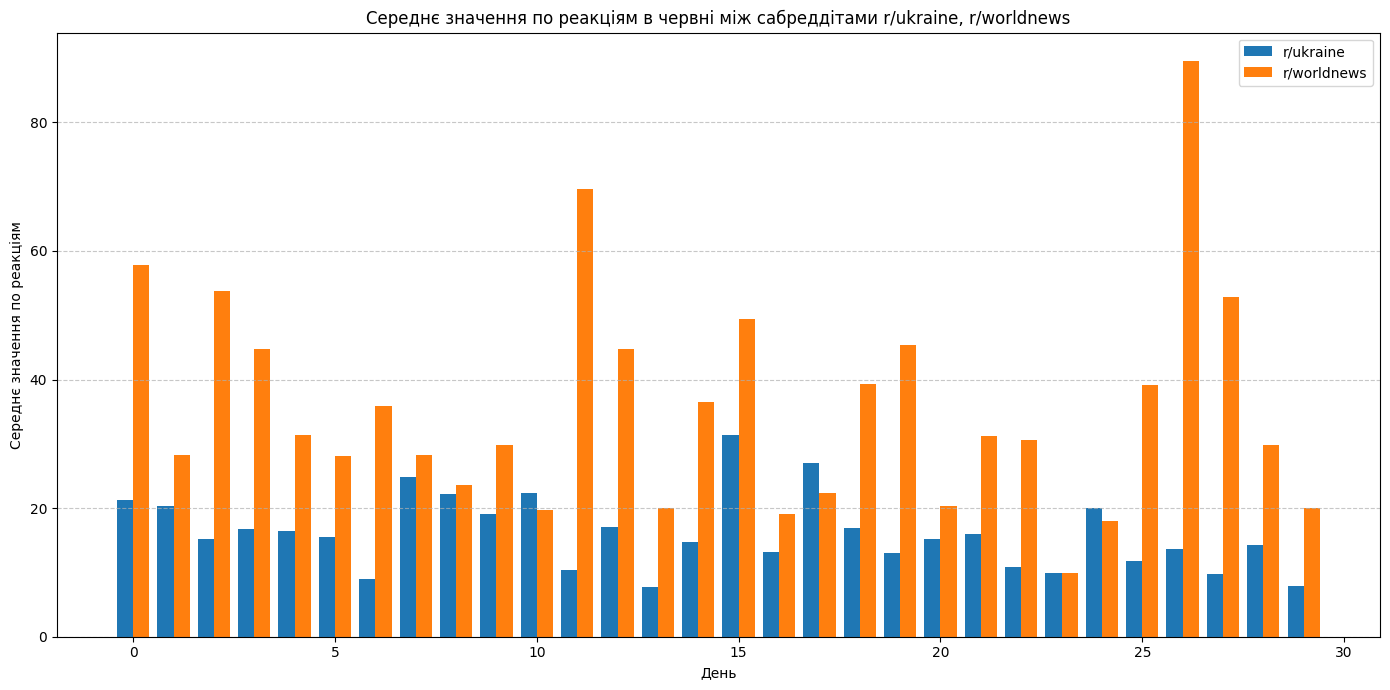

In [26]:
x = np.arange(len(ukraine_groupped_06_2025.loc["ukraine"]))
width = 0.4

plt.figure(figsize=(14,7))
plt.bar(x - width/2, ukraine_groupped_06_2025.loc["ukraine"]["mean"], width, label="r/ukraine", color="#1f77b4")
plt.bar(x + width/2, ukraine_groupped_06_2025.loc["worldnews"]["mean"], width, label="r/worldnews", color="#ff7f0e")

plt.xlabel("День")
plt.ylabel("Середнє значення по реакціям")
plt.title("Середнє значення по реакціям в червні між сабреддітами r/ukraine, r/worldnews")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Сабреддіт worldnews є одним з найбільших новинних сабреддітів. І доволі добре, що майже за кожен день середнє значення рейтингу коментарів є вищим, ніж в сабреддіті Україна. Це показує, що авдиторія реддіту досі підтримує Україну. Але це може бути оманливе враження, адже текст повідомлення може бути про те, що треба зменшувати допомогу Україні.

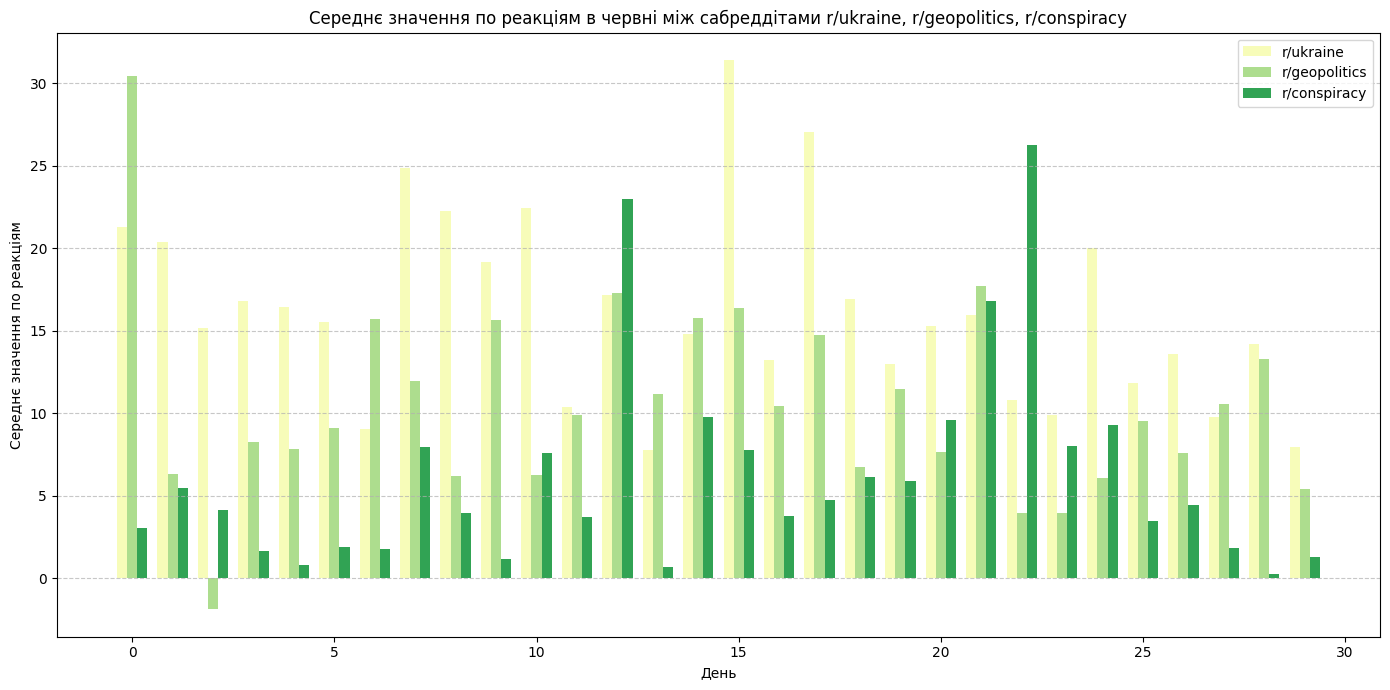

In [29]:
x = np.arange(len(ukraine_groupped_06_2025.loc["ukraine"]))
width = 0.25

plt.figure(figsize=(14,7))
plt.bar(x - width, ukraine_groupped_06_2025.loc["ukraine"]["mean"], width, label="r/ukraine", color="#f7fcb9")
plt.bar(x, ukraine_groupped_06_2025.loc["geopolitics"]["mean"], width, label="r/geopolitics", color="#addd8e")
plt.bar(x + width, ukraine_groupped_06_2025.loc["conspiracy"]["mean"], width, label="r/conspiracy", color="#31a354")


plt.xlabel("День")
plt.ylabel("Середнє значення по реакціям")
plt.title("Середнє значення по реакціям в червні між сабреддітами r/ukraine, r/geopolitics, r/conspiracy")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Як бачимо сабреддіти conspiracy та geopolitcs є дуже нестабільними щодо реакції авдиторії на коментарі, що скоріше означає, що частіше за все там намагаються виправдати дії росії у відповідь на що отримують незадоволені відгуки на ці коментарі.

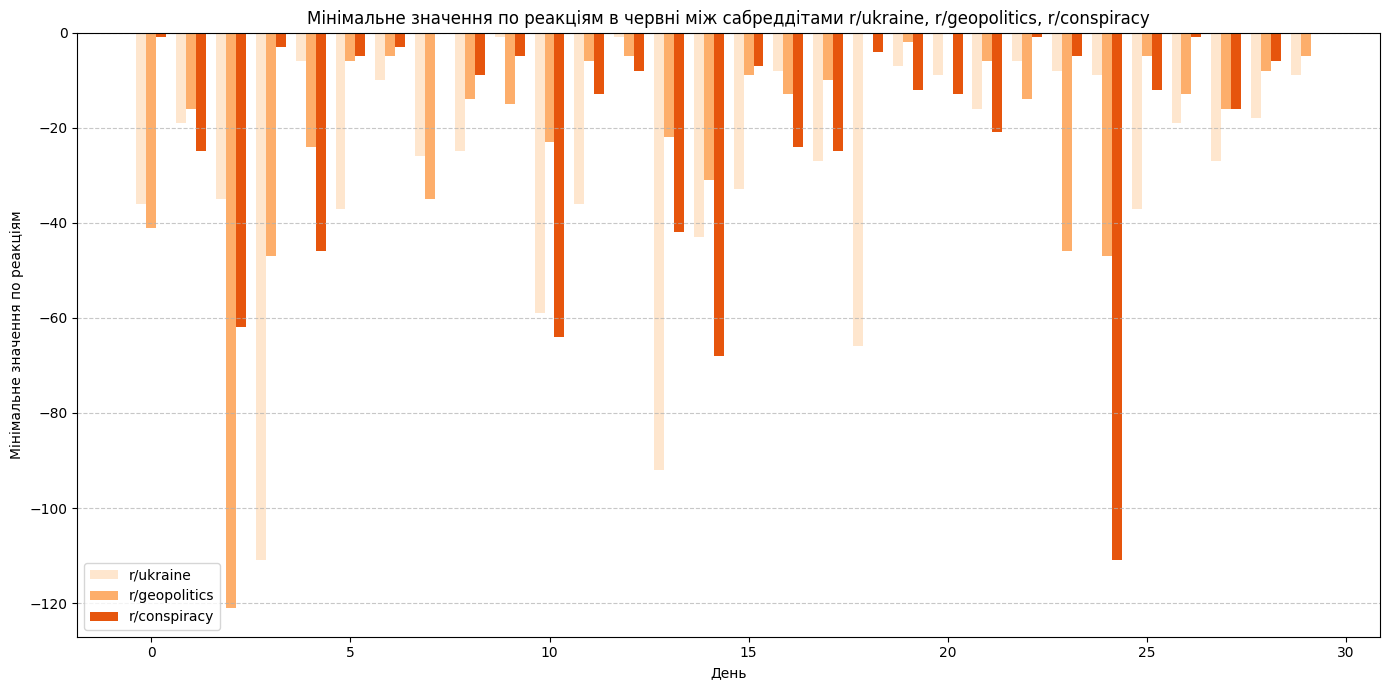

In [31]:
x = np.arange(len(ukraine_groupped_06_2025.loc["ukraine"]))
width = 0.25

plt.figure(figsize=(14,7))
plt.bar(x - width, ukraine_groupped_06_2025.loc["ukraine"]["min"], width, label="r/ukraine", color="#fee6ce")
plt.bar(x, ukraine_groupped_06_2025.loc["geopolitics"]["min"], width, label="r/geopolitics", color="#fdae6b")
plt.bar(x + width, ukraine_groupped_06_2025.loc["conspiracy"]["min"], width, label="r/conspiracy", color="#e6550d")


plt.xlabel("День")
plt.ylabel("Мінімальне значення по реакціям")
plt.title("Мінімальне значення по реакціям в червні між сабреддітами r/ukraine, r/geopolitics, r/conspiracy")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
from datetime import datetime
mask = (
    (RC_06_2025["subreddit"] == "geopolitics") &
    (RC_06_2025.index.date == datetime(2025, 6, 3).date())
)
subset = RC_06_2025[mask]
worst_comment = subset.sort_values(by="score").iloc[0]["text"]
print(worst_comment)



If Ukraine keeps nibbling away Russia nuclear triad Russia will have to nuke Ukraine thats they’re nuclear doctrine. Zelensky should tread carefully


По коментарю, який набрав найменший рівень підтримки, можемо зрозуміти, що авдиторія реддіту залишається доволі проукраїнською. Також нині заблокований сабреддіт russia, тому теоретично немає бути підтримки російської агресії.